In [284]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table

- [The Catalog site](https://heasarc.gsfc.nasa.gov/db-perl/W3Browse/w3table.pl?tablehead=name%3Dfermilgrb&Action=More+Options)
- [Feature key](https://heasarc.gsfc.nasa.gov/W3Browse/fermi/fermilgrb.html)

Only enforced parameter at query-level is that redshift "=null"

In [296]:
dat = Table.read('Query090822.fits')
targets = dat.to_pandas()

# Remove trailing whitespace
targets = targets.rename(columns=lambda x: x.strip().lower())

targets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186 entries, 0 to 185
Columns: 107 entries, name to gbm_cat_fluence_error
dtypes: float64(101), int16(2), object(4)
memory usage: 153.4+ KB


In [297]:
# Apply the flux_ratio calculations
targets['flux_ratio'] = targets['like_gbm_flux']/targets['like_lat_flux']
targets['flux_ene_ratio'] = targets['like_gbm_flux_ene']/targets['like_lat_flux_ene']
targets['fluence_ratio'] = targets['like_gbm_fluence']/targets['like_lat_fluence']

def propagate_error(a, b, e_a, e_b):
    return np.abs(a/b) * np.sqrt( (e_a/a)**2 + (e_b/b) )

targets['flux_ratio_error'] = propagate_error(targets['like_gbm_flux'],
                                              targets['like_lat_flux'],
                                              targets['like_gbm_flux_error'],
                                              targets['like_lat_flux_error'])

targets['flux_ene_ratio_error'] = propagate_error(targets['like_gbm_flux_ene'],
                                                  targets['like_lat_flux_ene'],
                                                  targets['like_gbm_flux_ene_error'],
                                                  targets['like_lat_flux_ene_error'])

targets['fluence_ratio_error'] = propagate_error(targets['like_gbm_fluence'],
                                                  targets['like_lat_fluence'],
                                                  targets['like_gbm_fluence_error'],
                                                  targets['like_lat_fluence_error'])

targets.describe()

,time,trigger_met,ra,dec,lii,bii,error_radius,redshift,luminosity_distance,theta,...,gbm_cat_t90_error,gbm_cat_t95,gbm_cat_fluence,gbm_cat_fluence_error,flux_ratio,flux_ene_ratio,fluence_ratio,flux_ratio_error,flux_ene_ratio_error,fluence_ratio_error
count,186.000000,1.860000e+02,186.000000,186.000000,186.000000,186.000000,186.000000,186.0,186.0,186.000000,...,186.000000,186.000000,186.000000,1.860000e+02,179.000000,179.000000,179.000000,128.000000,128.000000,128.000000
mean,57052.874966,4.443444e+08,176.550522,-3.777269,194.049015,3.114684,0.535414,0.0,0.0,49.575262,...,1.569591,47.459581,0.000039,7.702224e-08,inf,inf,inf,11.325593,11.153269,0.817412
std,1326.993839,1.146523e+08,98.276861,41.346603,105.880628,40.029953,1.185250,0.0,0.0,28.477461,...,1.756347,61.819373,0.000065,8.629224e-08,NaN,NaN,NaN,39.273526,30.768317,1.419890
min,54696.945012,2.407921e+08,1.360000,-79.920000,2.125500,-87.338400,0.000000,0.0,0.0,7.237200,...,0.000000,0.032000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,56020.165663,3.551183e+08,99.535000,-36.387500,99.651925,-27.050825,0.180000,0.0,0.0,29.080725,...,0.367250,12.768000,0.000004,2.941975e-08,0.107961,0.110371,0.050627,0.684146,0.904459,0.160888
50%,57013.097483,4.409076e+08,171.975000,-5.390000,206.623800,7.428950,0.310000,0.0,0.0,46.345150,...,0.815000,29.456000,0.000016,5.185300e-08,2.212876,1.807874,0.421541,2.184190,2.384681,0.481224
75%,58032.649572,5.289969e+08,248.546500,28.790000,282.058675,33.772950,0.617500,0.0,0.0,60.595450,...,2.111000,56.256250,0.000042,8.486550e-08,8.768265,9.472376,0.969111,6.045053,8.873443,1.019354
max,59677.311157,6.710957e+08,358.990000,79.020000,357.667300,86.368300,15.300000,0.0,0.0,165.907600,...,8.518000,450.823000,0.000522,5.681800e-07,inf,inf,inf,376.145817,253.125295,12.246271


There should be a negative correlation between burst duration and corresponding fluence ratio (0927-6505(96)00018-7, Figure 2.)

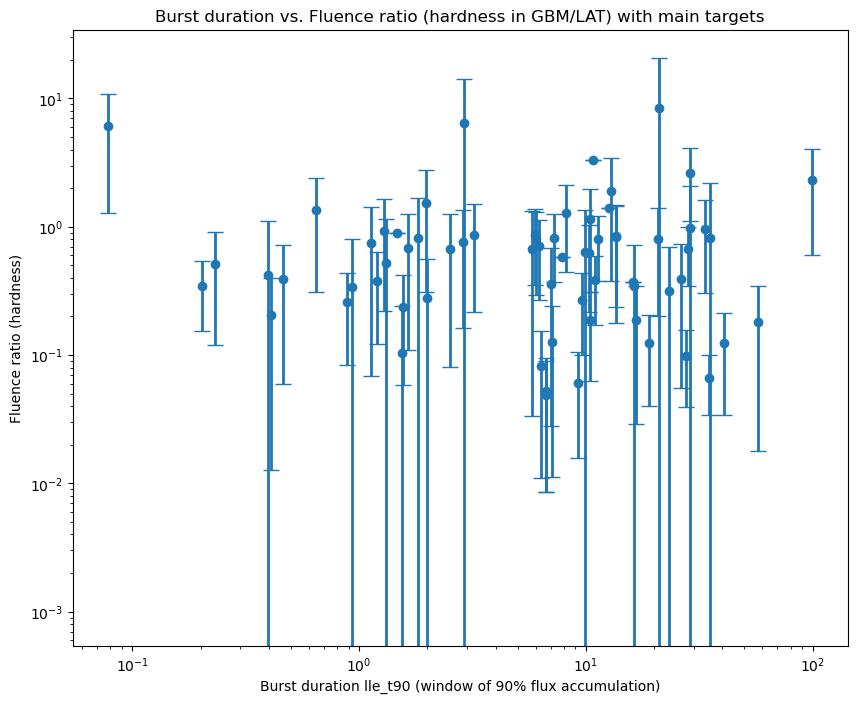

In [298]:
fig, ax = plt.subplots()
ax.errorbar(x = targets['lle_t90'], y=targets['fluence_ratio'], 
            yerr = targets['fluence_ratio_error'], fmt = 'o', linewidth = 2, capsize = 6)
ax.set_xlabel('Burst duration lle_t90 (window of 90% flux accumulation)')
ax.set_ylabel('Fluence ratio (hardness)')
fig.set_figwidth(10)
fig.set_figheight(8)
ax.set_title('Burst duration vs. Fluence ratio (hardness in GBM/LAT) with main targets')
ax.set_xscale('log')
ax.set_yscale('log')

Try to see if the considered correlation does exist by seeing if there's that negative correlation.

In [299]:
# Polyfit does not like NaNs or infs
print('Dropping %s targets for inf fluence_ratio'% len(targets.loc[targets['fluence_ratio'] == np.inf]) )
targets = targets.loc[ targets['fluence_ratio'] != np.inf ]
print('Dropping %s targets for NaN fluence_ratio'% len(targets.loc[ np.isnan(targets['fluence_ratio']) ]) )
targets = targets.loc[ ~np.isnan(targets['fluence_ratio']) ]

# These ones will have had a 0.0 in the LAT flux, causing a NaN
print('Dropping %s targets for NaN fluence_ratio_error'% len(targets.loc[ np.isnan(targets['flux_ratio_error']) ]) )
targets = targets.loc[ ~np.isnan(targets['fluence_ratio_error']) ]

# These ones will have had a 0.0 in GBM flux, causing a 0.
print('Dropping %s targets for 0. fluence_ratio_error'%len(targets[targets['flux_ratio_error'] ==0]))
targets = targets[targets['fluence_ratio_error'] !=0]

Dropping 8 targets for inf fluence_ratio
Dropping 7 targets for NaN fluence_ratio
Dropping 43 targets for NaN fluence_ratio_error
Dropping 14 targets for 0. fluence_ratio_error


Text(0.5, 0.01, 'Fluence ratio ~= hardness wrt. GBM and LAT -- GBM (10 keV - 25 MeV) / LAT (20 MeV - 300 MeV)')

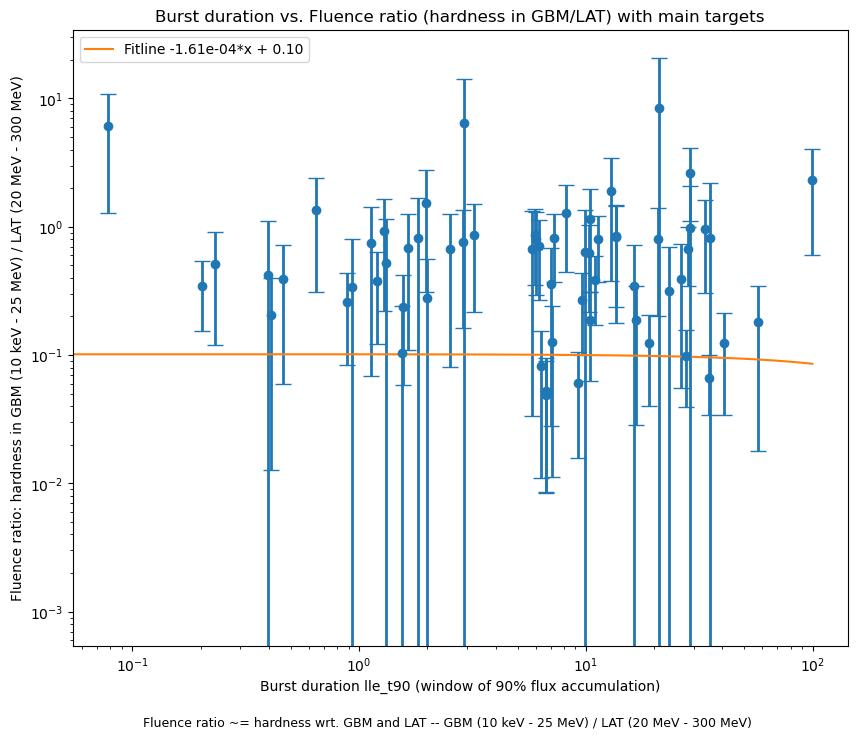

In [302]:
fit = np.polyfit(x = targets['lle_t90'], y = targets['fluence_ratio'], 
                 deg = 1, w = 1/targets['fluence_ratio_error'])

fig, ax = plt.subplots()
ax.errorbar(x = targets['lle_t90'], y=targets['fluence_ratio'], 
            yerr = targets['fluence_ratio_error'], fmt = 'o', linewidth = 2, capsize = 6)
ax.set_xlabel('Burst duration lle_t90 (window of 90% flux accumulation)')
ax.set_ylabel('Fluence ratio: hardness in GBM (10 keV - 25 MeV) / LAT (20 MeV - 300 MeV)')
fig.set_figwidth(10)
fig.set_figheight(8)
ax.set_title('Burst duration vs. Fluence ratio (hardness in GBM/LAT) with main targets')
#ax.set_xscale('log')

stats = targets['lle_t90'].describe()

time_domain = np.linspace(stats['min'], stats['max'], 100)

ax.plot(time_domain, time_domain*fit[0] + fit[1] 
        , '-', label = 'Fitline %.2e*x + %.2f'%(fit[0], fit[1]))
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()

plt.figtext(0.5, 0.01, 
            'Fluence ratio ~= hardness wrt. GBM and LAT -- GBM (10 keV - 25 MeV) / LAT (20 MeV - 300 MeV)', 
            horizontalalignment='center', fontsize=9)

In [303]:
fig.savefig('Burst_duration_vs_hardness.png')

-------
### Ignore below here!

In [228]:
print('This target has pretty gross error')

targets[ (targets['flux_ratio_error'] == targets['flux_ratio_error'].describe()['max'])]

This target has pretty gross error


,name,time,ra,dec,error_radius,lle_bbbd_sig,lle_t90,tl100,tl100_error,like_best_ts,...,like_gbm_t0,like_gbm_t1,like_gbm_flux,like_gbm_flux_error,like_gbm_flux_ene,like_gbm_flux_ene_error,flux_ratio,flux_ene_ratio,flux_ratio_error,flux_ene_ratio_error
142,GRB180305393,2018-03-05 09:26:07.996,03 18 40.8,+32 06 00,0.11,8.7,2.894,424.20999,424.20999,31.7423,...,1.536,14.592,0.000747,0.0,8.275770e-07,0.0,276.420285,208.824309,376.145817,253.125295


In [229]:
print('It\'s actually not bad! Still, bye for now.')
targets = targets[ ~(targets['flux_ratio_error'] == targets['flux_ratio_error'].describe()['max'])]
targets['flux_ratio_error'].describe()

It's actually not bad! Still, bye for now.


count    126.000000
mean       8.464923
std       22.224670
min        0.000000
25%        0.683525
50%        2.139088
75%        5.836302
max      166.456097
Name: flux_ratio_error, dtype: float64